# Opis środowiska eksperymentalnego

## Wykorzystane biblioteki i funkcje

In [1]:
import warnings

import numpy as np
from sklearn import svm
from sklearn.base import clone
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, RepeatedStratifiedKFold, train_test_split
from sklearn.neural_network import MLPClassifier

import parse_stroke_data_file

warnings.filterwarnings("ignore")


## Ewaluacja klasyfikatorów

Ewaluacja każdego klasyfikatora była wykonywana
z wykorzystaniem pięciokrotnie powtarzanej metody
2-krotnej walidacji krzyżowej

In [2]:
N_SPLITS = 2
N_REPEATS = 5

Badania były przeprowadzane dla różnej
liczby cech. Poczynając od jednej - najlepszej, według rankingu cech wyznaczonego za pomocą `SelectKBest`,
kolejno dodawane były kolejne cechy. Nasz zbiór danych miał 59 cech.


In [3]:
FEATURES_RANGE = range(1,8)

Do treningu wykorzystana została sieć jednokierunkowa z jedną warstwą ukrytą.
Sprawdziliśmy 3 różne liczby neuronów w warstwie ukrytej: 20, 50 oraz 90.
Przetestowane zostały klasyfikatory z parametrem `momentum` (pęd) o wartościach:

- 0: brak pędu
- 0.9: domyślny pęd w dla sztucznych sieci neuronowych w bibliotece `scikit-learn`

In [4]:
HIDDEN_LAYER_SIZES = [20, 50, 90]
MOMENTUM_VALUES = [0.0, 0.9]

# Implementacja środowiska eksperymentalnego

Kluczową część środowiska stanowi funkcja, generująca klasyfikatory. Każdy klasyfikator otrzymuje unikatową nazwę, opisującą jego konfigurację (liczbę cech, ilośc neuronów w ukrytych warstwach, wartość parametru `momentum`).

In [5]:
def get_classifiers():
    classifiers = {}
    for num_of_features in FEATURES_RANGE:
        for hidden_layer_size in HIDDEN_LAYER_SIZES:
            for momentum_value in MOMENTUM_VALUES:
                new_classifier = MLPClassifier(
                    hidden_layer_sizes=(hidden_layer_size,), momentum=momentum_value
                )

                new_classifier.num_of_features = num_of_features

                classifiers[(
                    num_of_features,
                    hidden_layer_size,
                    momentum_value
                )] = new_classifier

    return classifiers

Po wczytaniu zbioru uczącego, następuje ewaluacja każdego z klasyfikatorów. Proces ewaluacji składa się z:

- Załadowania odpowiedniego podzbioru zbioru uczącego (określonego przez liczbę cech, na jakich ma być trenowany klasyfikator)
- Pięciokrotna ewaluacja klasyfikatora na zbiorze danych, uczących i testowych, wygenerowanych za pomocą metody walidacji krzyżowej
- Zapisania sprawności klasyfikatora, policzonej za pomocą metody `accuracy_score`

Gdy wszystkie klasyfikatory zostały ocenione, ich sprawności zostają zapisane do pliku `results.npy`.

In [6]:
X, y = parse_stroke_data_file.get_dataset_x_y()
rskf = RepeatedStratifiedKFold(
    n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=42
)  # haha śmieszna liczba 42 haha
classifiers = get_classifiers()

scores = np.zeros((len(classifiers), N_SPLITS * N_REPEATS))

for clf_id, clf_name in enumerate(classifiers):
    X_new = SelectKBest(
        chi2, k=classifiers[clf_name].num_of_features
    ).fit_transform(X, y)

    for fold_id, (train, test) in enumerate(rskf.split(X_new, y)):
        clf = clone(classifiers[clf_name])
        clf.fit(X_new[train], y[train])
        y_pred = clf.predict(X_new[test])
        scores[clf_id, fold_id] = accuracy_score(y[test], y_pred)

mean = np.mean(scores, axis=1)
std = np.std(scores, axis=1)

# for clf_id, clf_name in enumerate(classifiers):
#     print("%s: %.3f (%.2f)" % (clf_name, mean[clf_id], std[clf_id]))

np.save("results", scores)

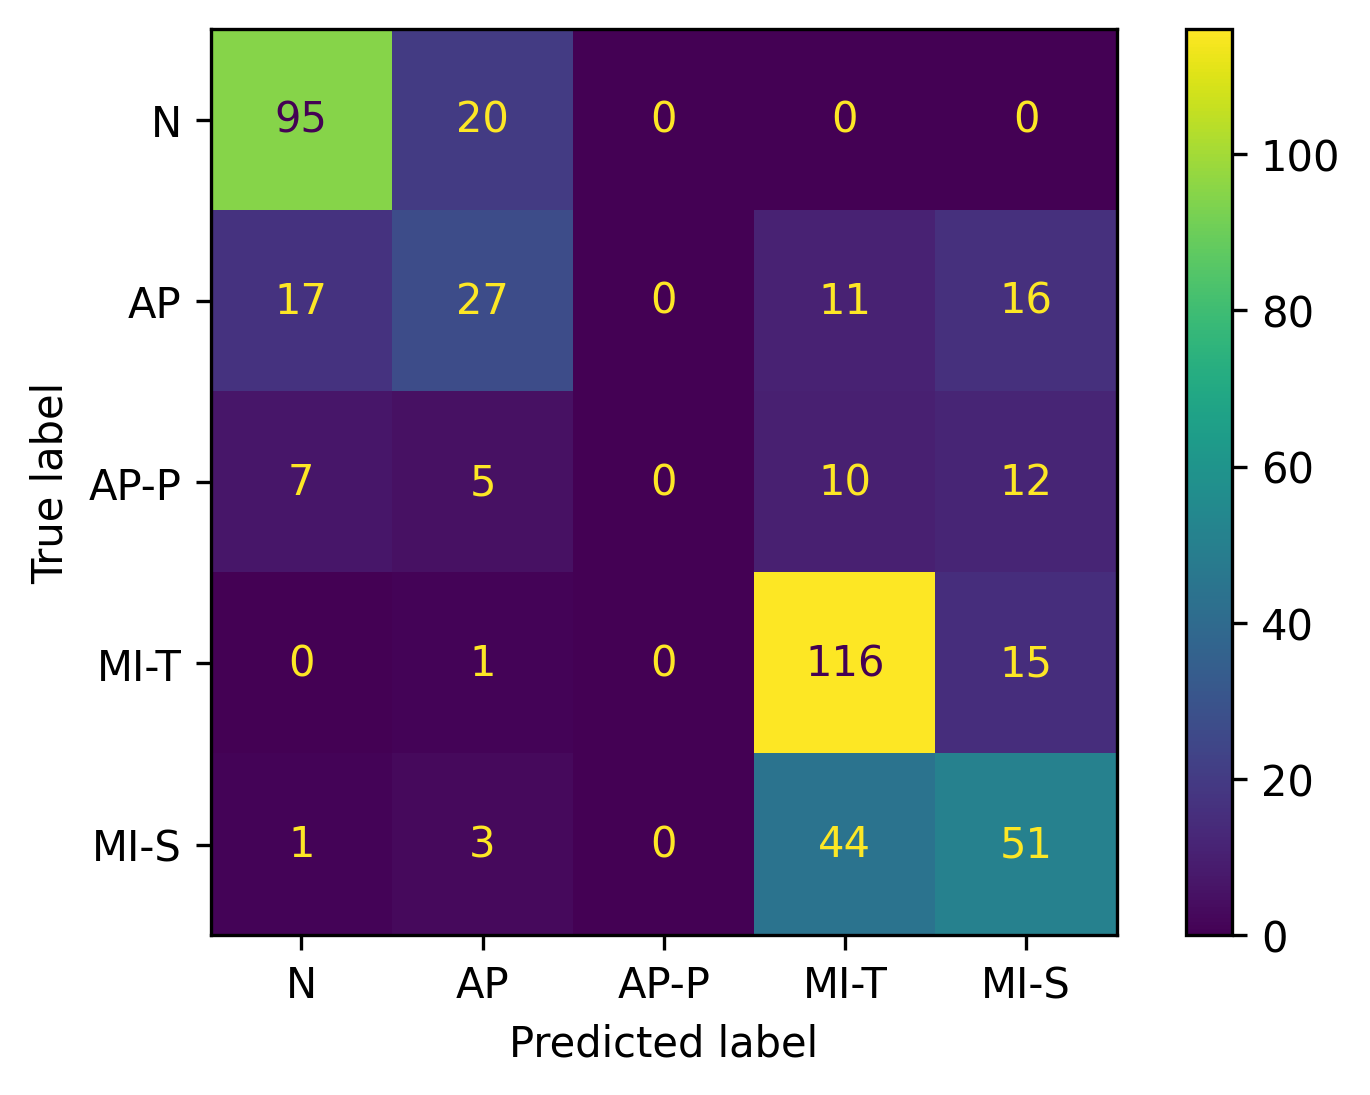

In [55]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

test_classifier = MLPClassifier(
    hidden_layer_sizes=(90,), momentum=0.9
)

X_new = SelectKBest(
    chi2, k=7
).fit_transform(X, y)

for fold_id, (train, test) in enumerate(rskf.split(X_new, y)):
        clf = clone(test_classifier)
        clf.fit(X_new[train], y[train])
        y_pred = clf.predict(X_new[test])
        scores[clf_id, fold_id] = accuracy_score(y[test], y_pred)
        
#         print(y_pred)
#         print(y[test])
        plot_confusion_matrix(clf, X_new[test], y[test], display_labels=[
            'N',
            'AP',
            'AP-P',
            'MI-T',
            'MI-S'
        ])
        plt.show()
        break
        


# Analiza wyników

## Wstępne przetwarzanie wyników

Przed przystąpieniem do analizy, dane klasyfikatorów i osiągnięte sprawności zostały załadowane do tabeli `pandas`.
Pozwoli to wykonanie kolejnych wykresów.

In [25]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300
from matplotlib.lines import Line2D
import pandas


clfs = get_classifiers()
scores = np.load("results.npy")

data_frame = None
first_element = True

results_python_dict = {
    'num_of_features': [ ],
    'hidden_layer_size': [ ],
    'momentum': [ ],
    'mean_score': [ ],
    'std_score': [ ]
}
for score, classifier in zip(scores, clfs):
    
    mean_score = np.mean(score)
    std_score = np.std(score)
    num_of_features, hidden_layer_size, momentum_value = classifier
    
    results_python_dict['num_of_features'].append(num_of_features)
    results_python_dict['hidden_layer_size'].append(hidden_layer_size)
    results_python_dict['momentum'].append(momentum_value)
    results_python_dict['mean_score'].append(mean_score)
    results_python_dict['std_score'].append(std_score)

results_pandas = pandas.DataFrame(results_python_dict)
del results_python_dict

print(results_pandas)

    num_of_features  hidden_layer_size  momentum  mean_score  std_score
0                 1                 20       0.0    0.307655   0.035183
1                 1                 20       0.9    0.293243   0.028576
2                 1                 50       0.0    0.293449   0.004974
3                 1                 50       0.9    0.281711   0.054228
4                 1                 90       0.0    0.292128   0.016088
5                 1                 90       0.9    0.293449   0.009151
6                 2                 20       0.0    0.456845   0.030765
7                 2                 20       0.9    0.459946   0.028713
8                 2                 50       0.0    0.467275   0.022491
9                 2                 50       0.9    0.465044   0.019913
10                2                 90       0.0    0.461059   0.024663
11                2                 90       0.9    0.461494   0.016835
12                3                 20       0.0    0.556503   0

## Sprawność klasyfikatorów a rozmiar warstwy ukrytej

Pierwszym krokiem podjętym w celu przeanalizowania wyników było utworzenie wykresu ilustrującego uzyskaną 
przez klasyfikatory sprawność, w zależności od liczby neuronów w ukrytych warstwach.

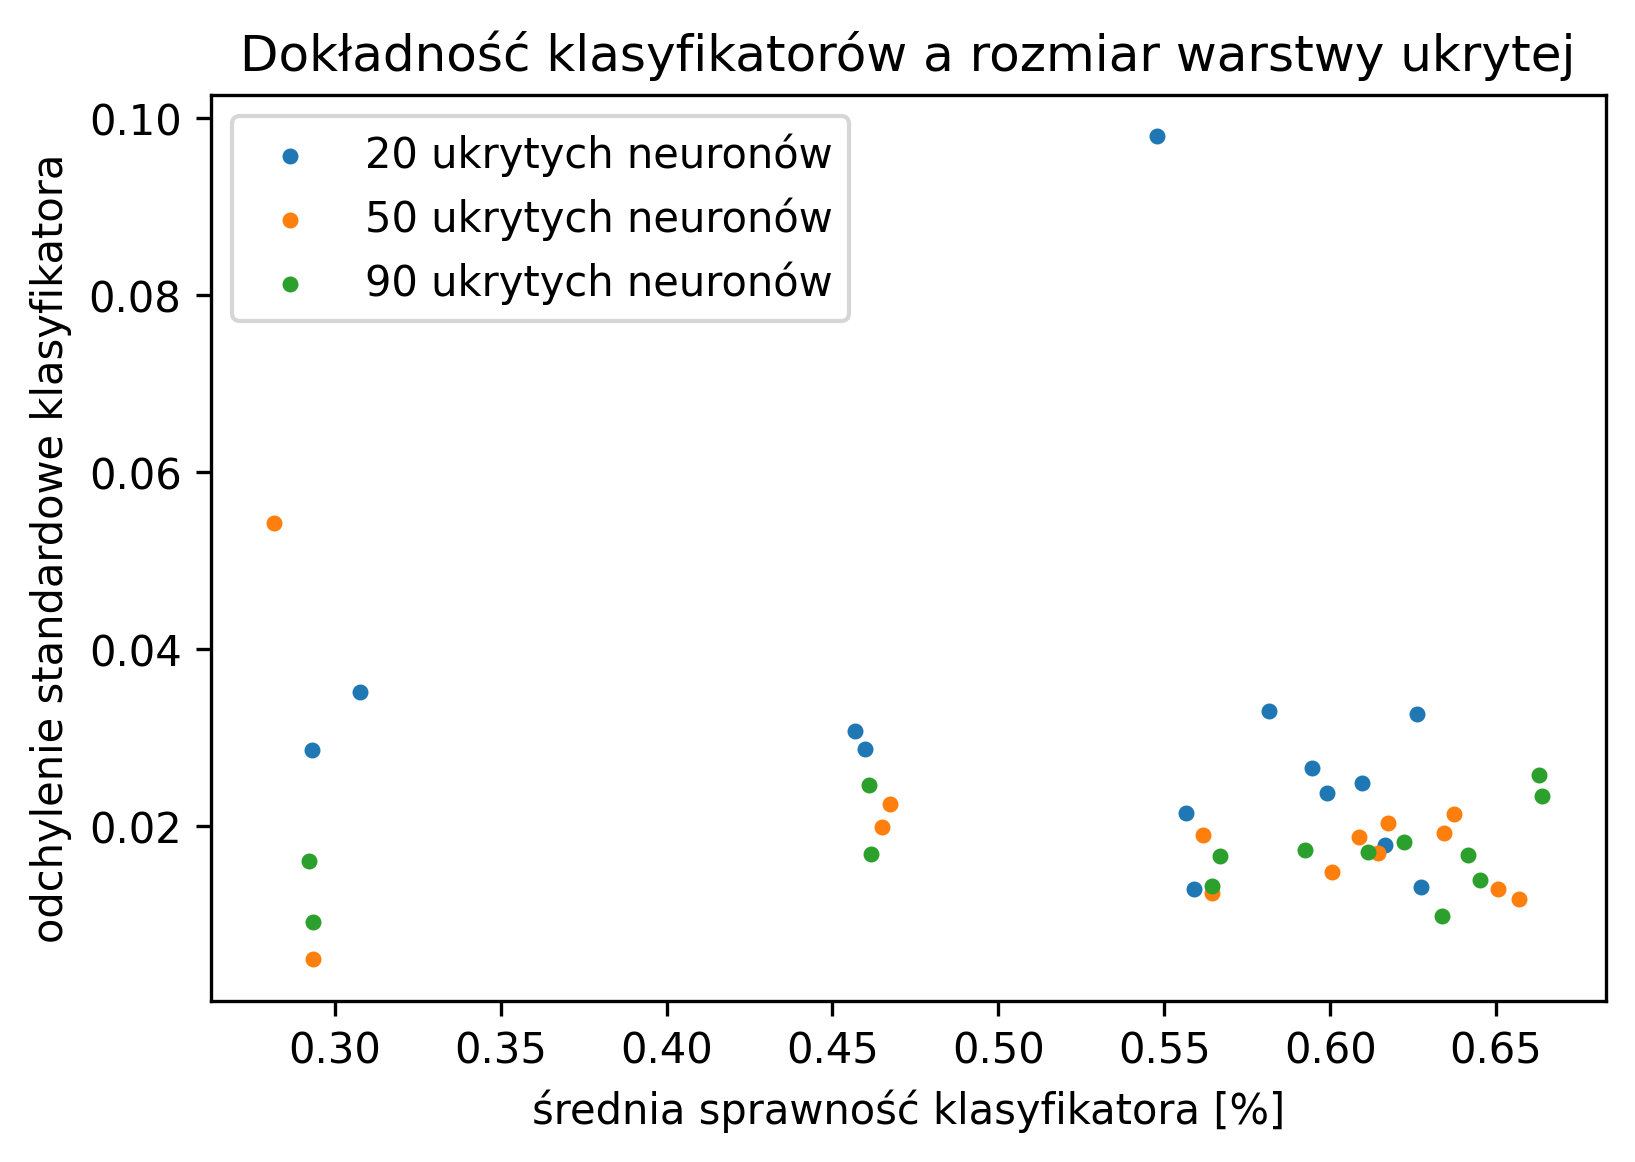

In [26]:
fig, ax = plt.subplots()

hidden_size_20 = results_pandas[results_pandas['hidden_layer_size'] == 20]
hidden_size_50 = results_pandas[results_pandas['hidden_layer_size'] == 50]
hidden_size_90 = results_pandas[results_pandas['hidden_layer_size'] == 90]

datas = [ hidden_size_20, hidden_size_50, hidden_size_90 ]
labels = [
    '20 ukrytych neuronów',
    '50 ukrytych neuronów',
    '90 ukrytych neuronów',
]

for data, label in zip(datas, labels):
    ax.scatter(
        data['mean_score'], data['std_score'], label=label, s=8
    )

plt.title('Dokładność klasyfikatorów a rozmiar warstwy ukrytej')
ax.set_xlabel('średnia sprawność klasyfikatora [%]')
ax.set_ylabel('odchylenie standardowe klasyfikatora')
ax.legend()
plt.show()

Na wykresie dostrzegalna jest przewaga klasyfikatorów o większej liczbie neuronów w warstwie ukrytej. 
Zarówno pod względem sprawności jak i odchylenia standardowego są one lepsze, niż klasyfikatory o mniejszej liczbie 
neuronów.

## Sprawność klasyfikacji a ilość cech

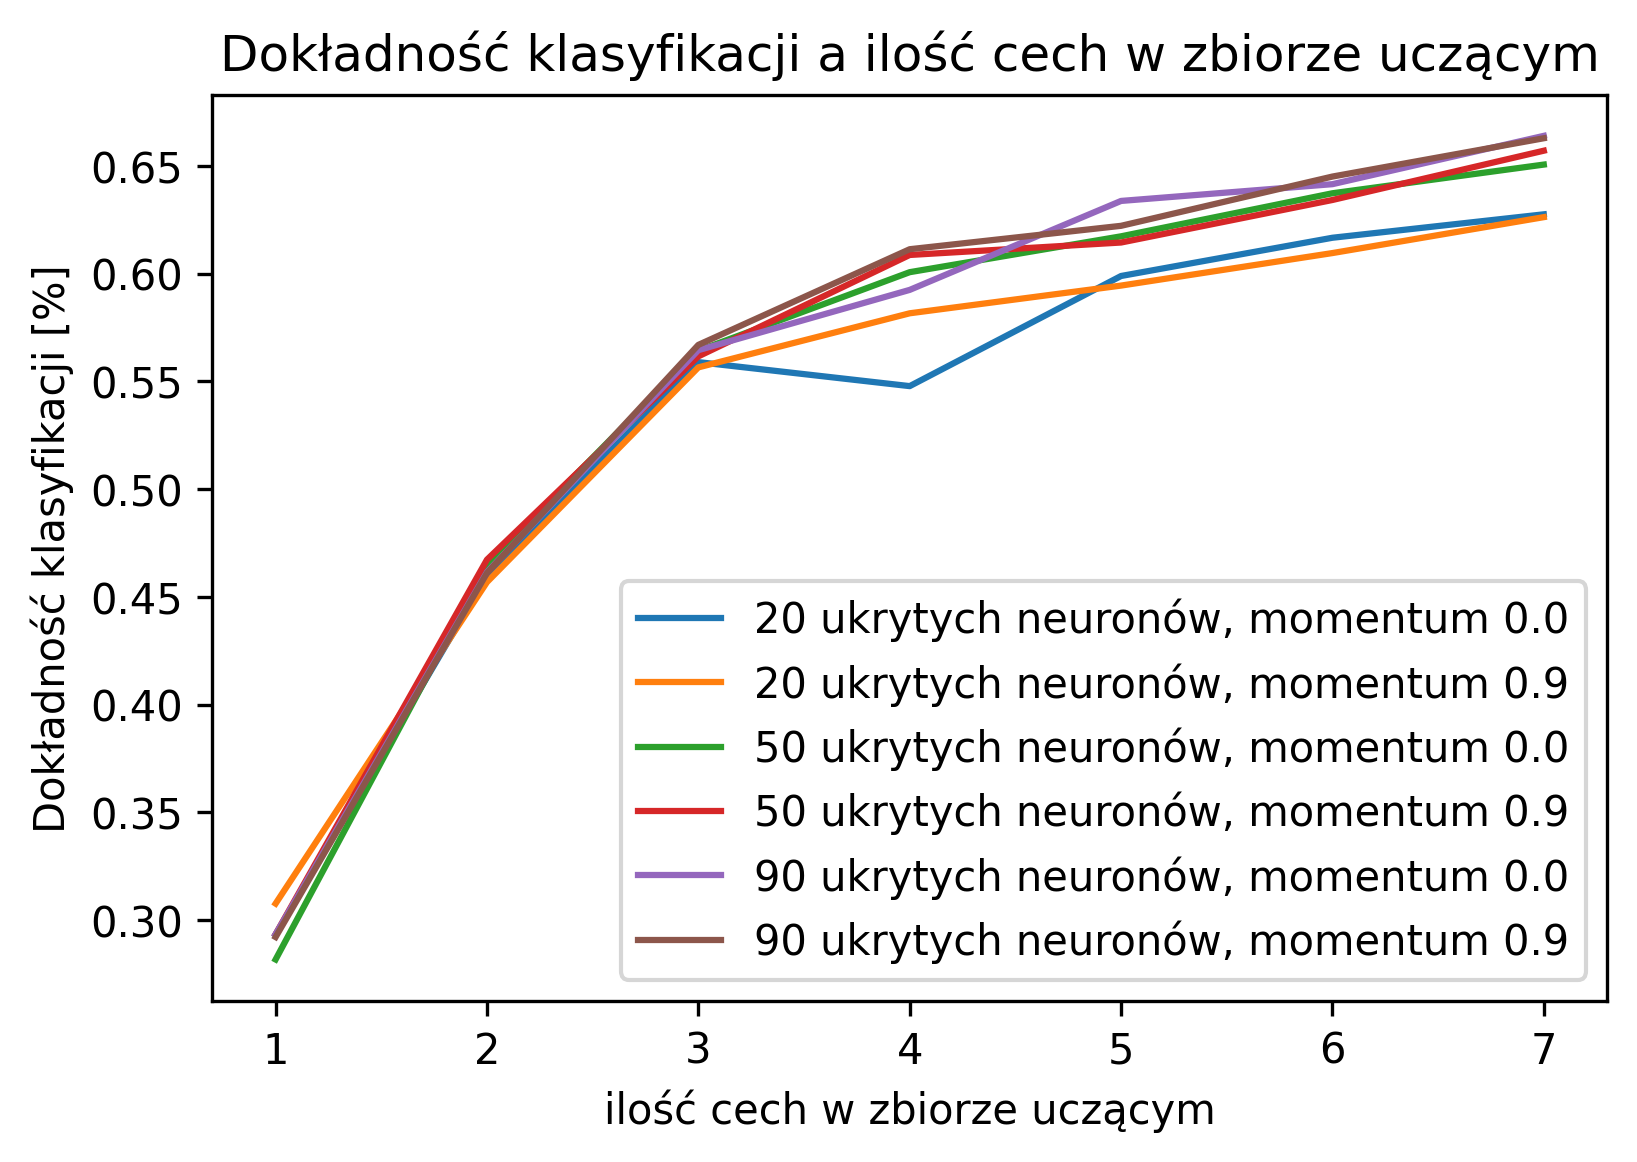

In [27]:
fig, ax = plt.subplots()

for hidden_layer_size in [20, 50, 90]:
    for momentum_value in [0.0, 0.9]:
        result = results_pandas[results_pandas['hidden_layer_size'] == hidden_layer_size]
        result = result[result['momentum'] != momentum_value]
        ax.plot(result['num_of_features'], result['mean_score'], label=f'{hidden_layer_size} ukrytych neuronów, momentum {momentum_value}')

ax.set_xlabel('ilość cech w zbiorze uczącym')
ax.set_ylabel('Dokładność klasyfikacji [%]')
plt.title('Dokładność klasyfikacji a ilość cech w zbiorze uczącym')
plt.legend()
plt.show()

W przypadku sieci neuronowych o 20 neuronach w warstwie ukrytej, skuteczność rozpoznawania wypłaszcza się po osiągnięciu 30 cech. Większe sieci nadal zwiększają swoją skuteczność, przypuszczalnie większa ilość cech pozwoliłaby osgiągnąć jeszcze lepszą dokładność.

## Najlepsze 10 sieci pod względem średniej skuteczności

In [28]:
top_10_by_acccuracy = results_pandas.sort_values(by='mean_score', ascending=False).head(10)
top_10_by_acccuracy

,num_of_features,hidden_layer_size,momentum,mean_score,std_score
41,7,90,0.9,0.663950,0.023402
40,7,90,0.0,0.662836,0.025778
38,7,50,0.0,0.657056,0.011755
39,7,50,0.9,0.650612,0.012924
34,6,90,0.0,0.645060,0.013974
35,6,90,0.9,0.641525,0.016763
33,6,50,0.9,0.637302,0.021378
32,6,50,0.0,0.634185,0.019225
29,5,90,0.9,0.633747,0.009862
37,7,20,0.9,0.627532,0.013199


Dostrzegalna jest zdecydowana przewaga sieci z dużą ilością neuronów w warstwie ukrytej.

## Najlepsze 10 sieci pod względem odchylenia standardowego

In [29]:
results_pandas.sort_values(by='std_score', ascending=True).head(10)

,num_of_features,hidden_layer_size,momentum,mean_score,std_score
2,1,50,0.0,0.293449,0.004974
5,1,90,0.9,0.293449,0.009151
29,5,90,0.9,0.633747,0.009862
38,7,50,0.0,0.657056,0.011755
15,3,50,0.9,0.564270,0.012448
39,7,50,0.9,0.650612,0.012924
13,3,20,0.9,0.558940,0.012955
37,7,20,0.9,0.627532,0.013199
17,3,90,0.9,0.564495,0.013278
34,6,90,0.0,0.645060,0.013974



## Analiza statystyczna z wykorzystaniem parowych testów T-studenta

In [30]:
from scipy.stats import ttest_ind
from tabulate import tabulate

alfa = 0.05
t_statistic = np.zeros((len(clfs), len(clfs)))
p_value = np.zeros((len(clfs), len(clfs)))

for i in range(len(clfs)):
    for j in range(len(clfs)):
        t_statistic[i, j], p_value[i, j] = ttest_ind(scores[i], scores[j])
# print("t-statistic:\n", t_statistic, "\n\np-value:\n", p_value)


In [31]:
headers = [key for key in clfs.keys()]
names_column = np.array([[str(key)] for key in clfs.keys()])

t_statistic_table = np.concatenate((names_column, t_statistic), axis=1)
t_statistic_table = tabulate(t_statistic_table, headers, floatfmt=".2f")
p_value_table = np.concatenate((names_column, p_value), axis=1)
p_value_table = tabulate(p_value_table, headers, floatfmt=".2f")
# print("t-statistic:\n", t_statistic_table, "\n\np-value:\n", p_value_table)


In [32]:

advantage = np.zeros((len(clfs), len(clfs)))
advantage[t_statistic > 0] = 1
advantage_table = tabulate(np.concatenate((names_column, advantage), axis=1), headers)
# print("Advantage:\n", advantage_table)

significance = np.zeros((len(clfs), len(clfs)))
significance[p_value <= alfa] = 1
significance_table = tabulate(
    np.concatenate((names_column, significance), axis=1), headers
)
# print("Statistical significance (alpha = 0.05):\n", significance_table)


stat_better = significance * advantage
stat_better_table = tabulate(
    np.concatenate((names_column, stat_better), axis=1), headers
)
# print("Statistically significantly better:\n", stat_better_table)

In [33]:
significantly_better = [ (sum(row), network_params, np.mean(score), np.std(score)) for row, network_params, score in zip(stat_better, names_column, scores) ]

significantly_better.sort(key=lambda value: value[0], reverse=True)
top_10_best_by_significance = significantly_better[:10]

top_10_best_by_significance_pandas.columns = ['better_than', '(features, hidden_layers, momentum)', 'mean score', 'std']
top_10_best_by_significance_pandas

NameError: name 'top_10_best_by_significance_pandas' is not defined

# Wnioski

- Skuteczność rozpoznawania rosła w miarę dodawania nowych cech:
    - Zatrzymując się przy ponad 30 cechach sieci z 20 neuronami w warstwie ukrytej
    - Nie przestawała rosnąć przy sieciach o 50 i 90 neuronach w warstwie ukrytej
- Sieci o ukrytej warstwie mniejszej niż 50 neuronów są zdecydowanie mniej skuteczne, niż większe sieci
- Parametr pęd (`momentum`) nie miał znaczącego wpływu na wynik. W rankingach pojawiły się sieci z różnymi wartościami parametru pędu
- Mimo teoretycznie większej średniej sprawności, sieci o największym (90) rozmiarze warstwy ukrytej, nie okazały się być znacznie skuteczniejsze w testach statystycznych
